## Metrics


In [1]:
import torchmetrics
from pathlib import Path

import datetime
from lib.dataloader import *


# Directory paths for semantic segmentation dataset
root_dir = Path("/home/emilia/WaterSegNet/datasets/complete_dataset/")
test_root = Path("/home/emilia/WaterSegNet/datasets/uav_dataset/")
dir_test_img = test_root / "test/images"
dir_test_mask = test_root / "test/labels"
dir_train_img = root_dir / "train/images"
dir_train_mask = root_dir / "train/labels"
dir_valid_img = root_dir / "valid/images"
dir_valid_mask = root_dir / "valid/labels"

# Directory paths for checkpoints and best models
dir_checkpoint = root_dir / "checkpoints/"
dir_best_model = root_dir / "best_models/"
dir_best_model /= datetime.datetime.now().strftime("%d-%m-%Y-%H-%M")


train_set = SegDataset(dir_train_img, dir_train_mask)
valid_set = SegDataset(dir_valid_img, dir_valid_mask)
test_set = SegDataset(dir_test_img, dir_test_mask)
data_module = SegDataModule(train_set, valid_set, test_set, batch_size=16)


metrics = torchmetrics.MetricCollection(
    torchmetrics.Accuracy(task="binary", num_classes=1, multiclass=False),
    torchmetrics.Recall(task="binary", num_classes=1, multiclass=False),
    torchmetrics.Precision(task="binary", num_classes=1, multiclass=False),
    torchmetrics.F1Score(
        task="binary", num_classes=1, multiclass=False
    ),  # Dice Coefficient
)

train_metrics = torchmetrics.MetricTracker(metrics)
val_metrics = torchmetrics.MetricTracker(metrics)
test_metrics = torchmetrics.MetricTracker(metrics)

## Models


In [2]:
import segmentation_models_pytorch as smp
from segnet.SegNet_model import *

Unet_model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation=None,
)

Unet_plus_plus_model = smp.UnetPlusPlus(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation=None,
)

FPN_model = smp.FPN(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation=None,
)

SegNet_model = SegNet(
    n_channels=3,
    n_classes=1,
)

models = {
    "Unet": Unet_model,
    "Unetplusplus": Unet_plus_plus_model,
    "FPN": FPN_model,
    "SegNet": SegNet_model,
}

/home/emilia/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
from lib.train import *
import segmentation_models_pytorch as smp
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning import Trainer


model_name = "Unet"
model = models[model_name]

seg_model = SegModel(
    model,
    lr=1e-3,
    optimizer_type="adam",
    train_metrics=train_metrics,
    val_metrics=val_metrics,
    test_metrics=test_metrics,
    freeze_encoder=False,
)


checkpoints_sets = {
    "Satelite": "/home/emilia/WaterSegNet/checkpoints/checkpoints_satelite/model-unet_resnet34_adam_padded_b16-v1.ckpt",
    "UAV": "/home/emilia/WaterSegNet/checkpoints/checkpoints_padded/model-unet_resnet34_adam_b16.ckpt",
    "FULL": "/home/emilia/WaterSegNet/checkpoints/checkpoints_full/model-unet_resnet34_adam_padded_b16.ckpt",
    "Sat+UAV": "/home/emilia/WaterSegNet/checkpoints/checkpoints_sat_to_uav/model-unet_resnet34_adam_padded_b16.ckpt",
}

checkpoints_early = {
    "Early_Stopping_20": "/home/emilia/WaterSegNet/checkpoints/checkpoints_padded/model-unet_resnet34_adam_padded_b16_e20.ckpt",
    "Early_Stopping_10": "/home/emilia/WaterSegNet/checkpoints/checkpoints_padded/model-unet_resnet34_adam_b16.ckpt",
}

checkpoints_dist_vs_pad = {
    "Distorted": "/home/emilia/WaterSegNet/checkpoints/checkpoints_distorted/model-Unet_adam_b16_e20.ckpt",
    "Padded": "/home/emilia/WaterSegNet/checkpoints/checkpoints_padded/model-unet_resnet34_adam_padded_b16_e20.ckpt",
}

checkpoints_models = {
    "Unet": "/home/emilia/WaterSegNet/checkpoints/checkpoints_padded/model-unet_resnet34_adam_b16.ckpt",
    "Unetplusplus": "/home/emilia/WaterSegNet/checkpoints/checkpoints_padded/model-unetplusplus_resnet34_adam_b16.ckpt",
    "FPN": "/home/emilia/WaterSegNet/checkpoints/checkpoints_padded/model-fpn_resnet34_adam_b16.ckpt",
    "SegNet": "/home/emilia/WaterSegNet/checkpoints/checkpoints_padded/model-segnet_adam_b16.ckpt",
}

checkpoints_batch = {
    "Batch 4": "/home/emilia/WaterSegNet/checkpoints/checkpoints_padded/model-unet_resnet34_adam_b4.ckpt",
    "Batch_8": "/home/emilia/WaterSegNet/checkpoints/checkpoints_padded/model-unet_resnet34_adam_b8.ckpt",
    "Batch_16": "/home/emilia/WaterSegNet/checkpoints/checkpoints_padded/model-unet_resnet34_adam_b16.ckpt",
    "Batch_32": "/home/emilia/WaterSegNet/checkpoints/checkpoints_padded/model-unet_resnet34_adam_b32.ckpt",
}

ckps = checkpoints_dist_vs_pad
trainer = Trainer(
    max_epochs=200,
    gpus=1 if torch.cuda.is_available() else 0,
    precision=16,  # Mixed precision training
    logger=False,
)
for i in ckps:
    print(i)
    results = trainer.test(
        seg_model,
        ckpt_path=ckps[i],
        datamodule=data_module,
        verbose=False,
    )
    print(results)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/emilia/.local/lib/python3.10/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
Restoring states from the checkpoint path at /home/emilia/WaterSegNet/checkpoints/checkpoints_distorted/model-Unet_adam_b16_e20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/emilia/WaterSegNet/checkpoints/checkpoints_distorted/model-Unet_adam_b16_e20.ckpt


Distorted
Testing: 100%|██████████| 55/55 [00:01<00:00, 32.45it/s]


/home/emilia/.local/lib/python3.10/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(
Restoring states from the checkpoint path at /home/emilia/WaterSegNet/checkpoints/checkpoints_padded/model-unet_resnet34_adam_padded_b16_e20.ckpt


[{'test_loss': 4.166417121887207, 'test.Accuracy': 0.7387941479682922, 'test.Recall': 0.7387941479682922, 'test.Precision': 0.7360867857933044, 'test.F1Score': 0.7372997999191284}]
Padded


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/emilia/WaterSegNet/checkpoints/checkpoints_padded/model-unet_resnet34_adam_padded_b16_e20.ckpt


Testing: 100%|██████████| 55/55 [00:01<00:00, 33.58it/s]
[{'test_loss': 0.0805499330163002, 'test.Accuracy': 0.7464132308959961, 'test.Recall': 0.7464132308959961, 'test.Precision': 0.7439584732055664, 'test.F1Score': 0.7450493574142456}]


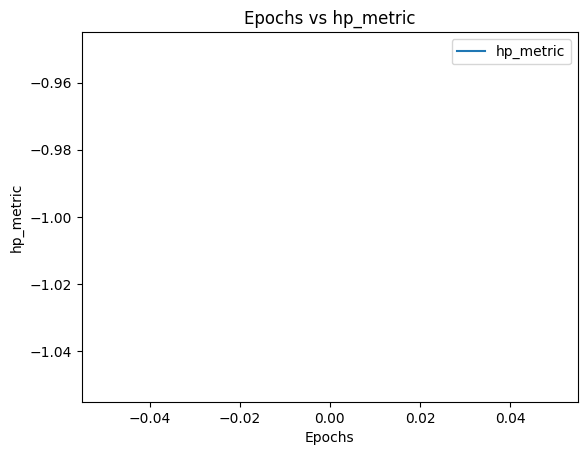

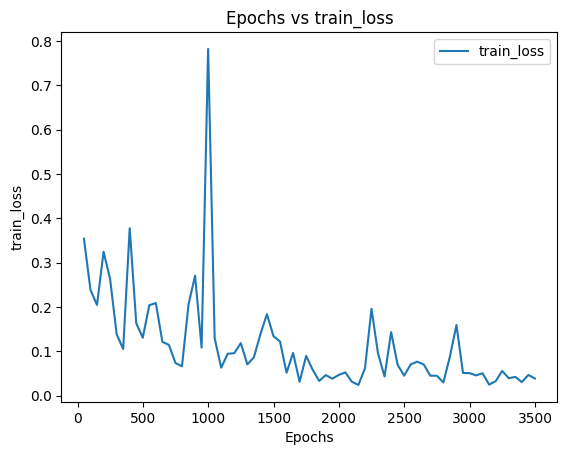

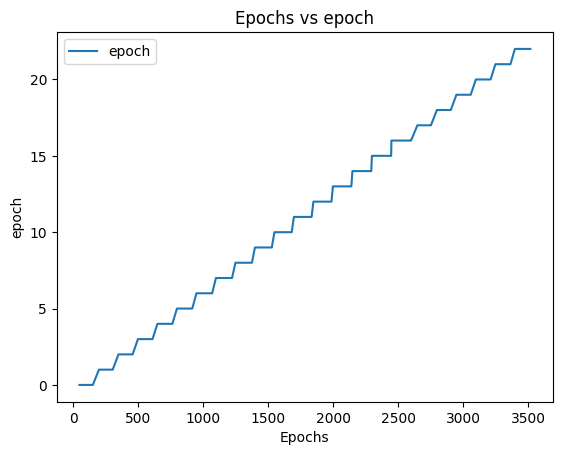

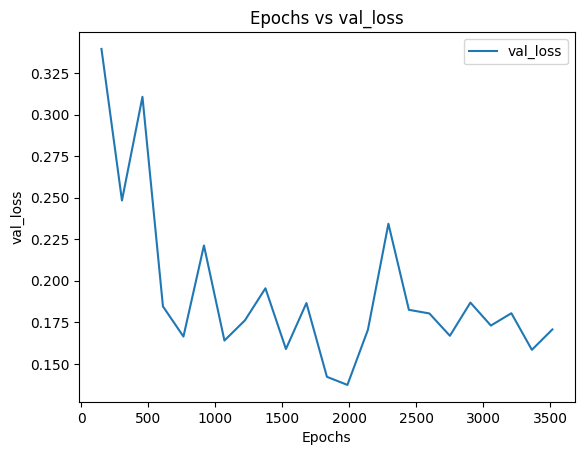

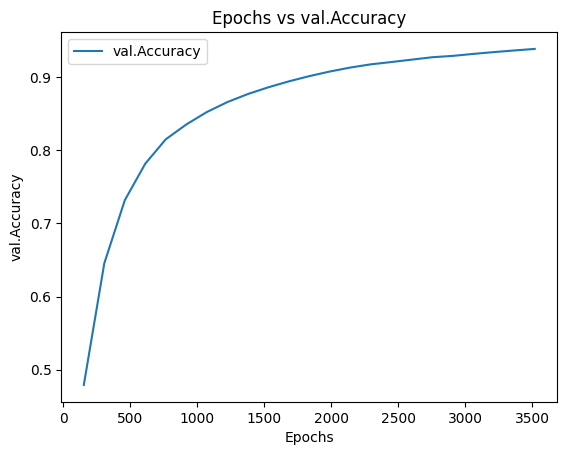

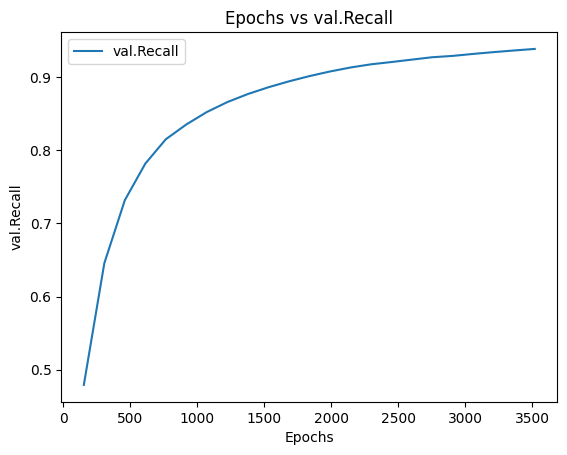

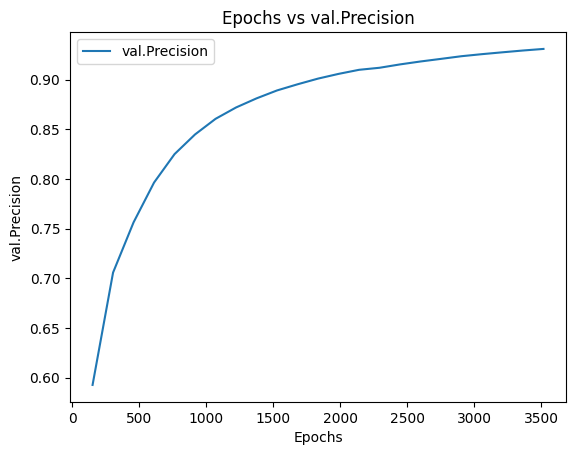

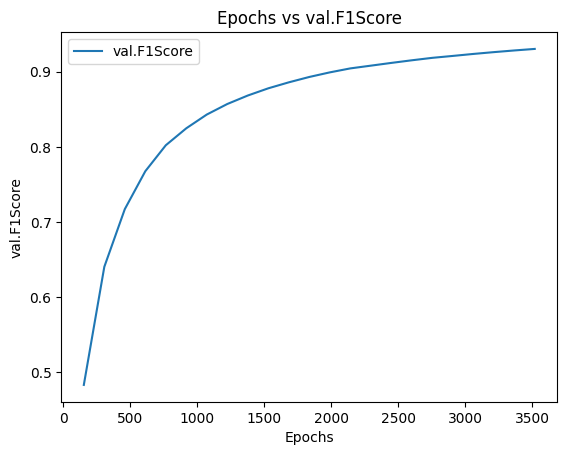

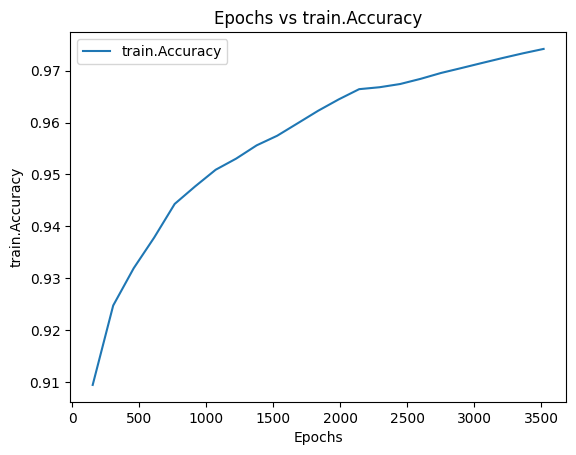

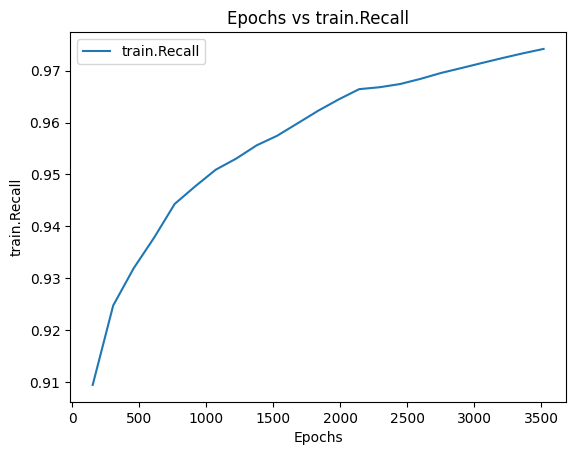

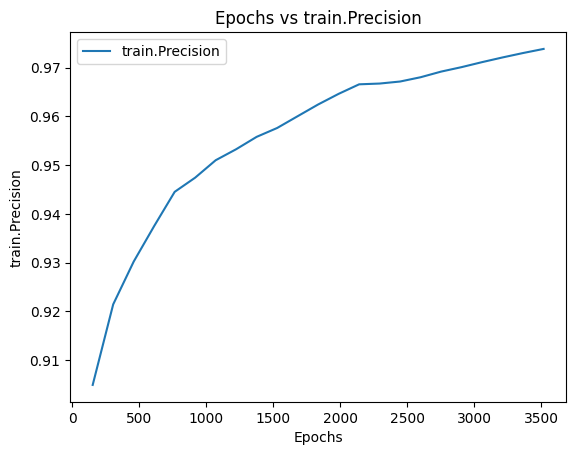

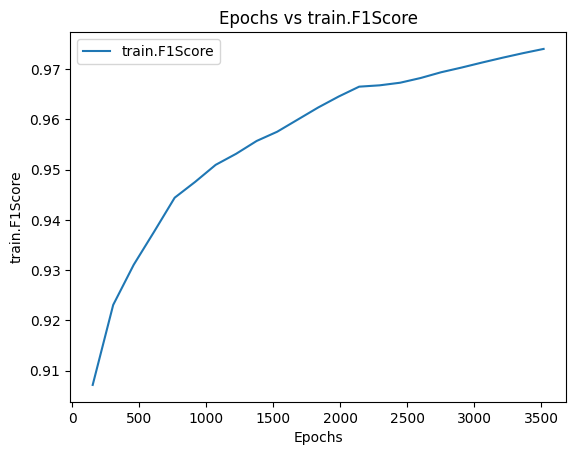

['hp_metric',
 'train_loss',
 'epoch',
 'val_loss',
 'val.Accuracy',
 'val.Recall',
 'val.Precision',
 'val.F1Score',
 'train.Accuracy',
 'train.Recall',
 'train.Precision',
 'train.F1Score']

In [12]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
import pandas as pd

log_dir = "/home/emilia/WaterSegNet/lightning_logs/uav/distorted/FPN_adam/version_0/"

ea = EventAccumulator(log_dir)
ea.Reload()

metrics = ea.scalars.Keys()


for metric in metrics:
    # Extract data
    data = ea.scalars.Items(metric)
    epochs = [i.step for i in data]
    values = [i.value for i in data]

    # Create a DataFrame
    df = pd.DataFrame({"epoch": epochs, "value": values})

    # Group by epoch and calculate mean
    epoch_means = df.groupby("epoch")["value"].mean().reset_index()

    # Plotting
    plt.figure()
    plt.plot(epoch_means["epoch"], epoch_means["value"], label=metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.title(f"Epochs vs {metric}")
    plt.legend()
    plt.show()

metrics